# Pre/Post Processing for ImageNet based classification model
### First check onnxruntime-extensions is installed in the Python environment

In [3]:
!pip show onnxruntime_extensions
from matplotlib.pyplot import imshow

Name: onnxruntime-extensions
Version: 0.4.2+febe63a
Summary: ONNXRuntime Extensions
Home-page: https://github.com/microsoft/onnxruntime-extensions
Author: Microsoft Corporation
Author-email: onnx@microsoft.com
License: MIT License
Location: c:\g\ortext
Requires: numpy, onnx, onnxruntime
Required-by: 


Load an image for test

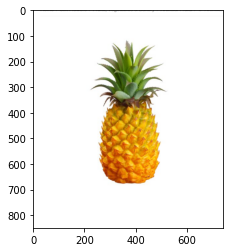

In [4]:
import numpy
from PIL import Image
img = Image.open('../test/data/pineapple.jpg')
img_npy = numpy.asarray(img.convert('RGB'))
img.size, img_npy.shape
%matplotlib inline
imshow(img)

Try the pre-processing built-in Python function in onnxruntime_extensions, Note the normalized image was miscolored due to the image RGB value normalization.

c:\g\ortext\onnxruntime_extensions\pnp\_onnx_ops.py:71: UserWarning: The maximum opset needed by this model is only 9.
  warnings.warn('The maximum opset needed by this model is only %d.' % op_version)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


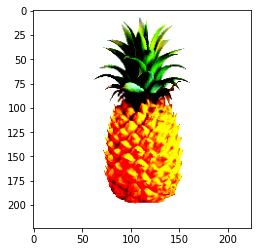

In [5]:
from onnxruntime_extensions import pnp
pre = pnp.PreMobileNet(size=224)
img2 = pre.forward(img_npy)
%matplotlib inline
imshow(img2.squeeze(0).permute(1, 2, 0))

Try the pre-processing in torchvision

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


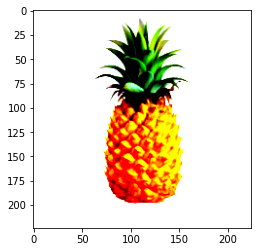

In [6]:
from torchvision import transforms as T
pre_torch=T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
   )
])

img3 = pre_torch(img.convert('RGB'))
%matplotlib inline
imshow(img3.permute(1, 2, 0))

The processed images are identical after the different processing ways.

### Integrate the preprocessing into a model trained on ImageNet dataset

In [13]:
import onnx
import torch
from onnxruntime_extensions import PyOrtFunction, pnp


mnv2 = onnx.load_model('../test/data/mobilev2.onnx')
full_model = pnp.SequenceProcessingModule(pnp.PreMobileNet(224),
                                          mnv2,
                                          pnp.PostMobileNet())

ids, probabilities = full_model.forward(torch.from_numpy(img_npy))
full_onnx_model = pnp.export(full_model, torch.from_numpy(img_npy), opset_version=11, output_path='temp_exmobilev2.onnx')

### Verify the built full model
Let me try the model embedded with preprocessing operations

In [11]:
full_model_func = PyOrtFunction.from_model(full_onnx_model)
ids, probabilities = full_model_func(img_npy)
ids[0][0]

953

Convert the the image class id number to image class text.

In [12]:
import ast
idx = ids[0][0].item()
text = "{}".format(idx)
with open('../test/data/imagenet1000_clsidx_to_labels.txt', 'r') as f:
    labels = ast.literal_eval(f.read())
    text = labels[idx]
print("top-1 obj={} prob={:.2%}".format(text, probabilities[0][0]))

top-1 obj=pineapple, ananas prob=99.85%
